<a href="https://colab.research.google.com/github/LeeSeungwon89/Machine-learning_Theory/blob/master/CHAPTER4%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%ED%91%9C%ED%98%84%EA%B3%BC%20%ED%8A%B9%EC%84%B1%20%EA%B3%B5%ED%95%99.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 들어가며

2차원 실수형 배열을 가진 데이터로서 각 열이 샘플에 대해 설명하면 연속형 특성(continuous feature)이라고 가정했습니다. 하지만 많은 애플리케이션에서는 이렇게 데이터가 수집되지 않습니다. 일반적인 특성의 전형적인 형태는 숫자 값이 아닌 범주형 특성(categorical feature)(=이산형 특성(discrete feature))입니다.

연속형 특성과 범주형 특성은 회귀와 분류의 차이와 비슷합니다. 다만 출력이 아닌 입력에 대한 것이란 점에서 차이가 있습니다. 앞서 살폈던 연속형 특성의 예는 픽셀 밝기, 붓꽃 측정값입니다. 범주형 특성의 예는 제품 브랜드, 색상, 판매 분류(책, 옷, 하드웨어) 등입니다. 이런 특성들은 모두 상품을 묘사하는 속성이므로 연속된 값이 아닙니다. 제품과 제품 간에는 중간값이 없고 순서도 없습니다.

하지만 데이터의 특성이 어떤 형태를 취하는지보다 중요한 것은 데이터를 표현하는 방식입니다. 이 방식에 따라 머신러닝 모델 성능에 주는 영향이 큽니다. 데이터의 스케일을 조정하는 것이 매우 중요하다는 점을 강조했습니다. 예를 들면 측정치의 스케일을 조정하지 않았을 때 센티미터, 인치의 기준에 따라 큰 차이가 생깁니다. 스케일 조정뿐만 아니라 특성의 상호작용(특성 간의 곱)이나 일반적인 다항식을 추가 특성으로 넣는 것도 방법입니다.

특정 애플리케이션에 가장 적합한 데이터 표현을 찾는 것을 '특성 공학(feature engineering)'이라고 합니다. 올바른 데이터 표현을 찾는다면 지도 학습 모델에서 적절한 매개변수를 선택하는 것보다 모델 성능을 더 크게 제고할 수 있습니다.

# 4.1 범주형 변수

예제에 사용할 데이터는 [1994년 인구 조사 데이터베이스에서 추출한 미국 성인의 소득 데이터셋](https://github.com/rickiepark/introduction_to_ml_with_python/blob/master/data/adult.data)입니다. 이 데이터셋을 사용해서 특정 근로자의 수입이 50,000달러를 초과하는지 이하인지를 예측하고자 합니다.

In [89]:
pip install mglearn

In [90]:
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
%matplotlib inline

In [91]:
# 데이터셋 10개를 부르기 위한 코드입니다.
# 코드는 뒤에서 다시 설명합니다.
import os

data = pd.read_csv(os.path.join(mglearn.datasets.DATA_PATH, 'adult.data'),
                   header=None, index_col=False,
                   names=['age', 'workclass', 'fnlwgt', 'education',
                          'education-num', 'marital-status', 'occupation',
                          'relationship', 'race', 'gender', 'capital-gain',
                          'capital-loss', 'hours-per-week', 'native-country',
                          'income'])
data = data[['age', 'workclass', 'education', 'gender', 'hours-per-week',
             'occupation', 'income']]
display(data.head(11))

,age,workclass,education,gender,hours-per-week,occupation,income
0,39,State-gov,Bachelors,Male,40,Adm-clerical,<=50K
1,50,Self-emp-not-inc,Bachelors,Male,13,Exec-managerial,<=50K
2,38,Private,HS-grad,Male,40,Handlers-cleaners,<=50K
3,53,Private,11th,Male,40,Handlers-cleaners,<=50K
4,28,Private,Bachelors,Female,40,Prof-specialty,<=50K
5,37,Private,Masters,Female,40,Exec-managerial,<=50K
6,49,Private,9th,Female,16,Other-service,<=50K
7,52,Self-emp-not-inc,HS-grad,Male,45,Exec-managerial,>50K
8,31,Private,Masters,Female,50,Prof-specialty,>50K
9,42,Private,Bachelors,Male,40,Exec-managerial,>50K


데이터셋에는 여러 특성이 있습니다. 근로자 나이(age), 고용형태(workclass), 교육수준(education), 성별(gender), 주당 근로시간(hours-per-week), 직업(occupation) 등입니다.

이 예측 작업은 소득(income)이 <=50k, >50k라는 두 클래스를 가진 분류 문제입니다. 정확한 소득을 예측하고자 한다면 회귀 문제입니다.

이 데이터셋에 있는 'age'와 'hours-per-week'는 연속형 특성입니다. 그리고 'workclass', 'education', 'sex', 'occupation'은 범주형 특성입니다. 범위가 아닌 고정된 목록 중에 하나를 값으로 가지며 정성적(qualitative)입니다.

먼저 로지스틱 회귀 분류기를 학습시킵니다. 공식을 다시 서술하면 아래와 같습니다. 

$\hat{y}=w[0] \times x[0] + w[1] \times x[1] + \cdots +w[p] \times x[p] + b > 0$

$w[i]$와 $b$는 훈련 세트로부터 학습되는 계수이고 $x[i]$는 입력 특성입니다. $x[i]$는 숫자여야 하므로 $x[2]$는 'masters'나 'Bachelors'가 될 수 없습니다. 따라서 로지스틱 회귀를 사용하려면 데이터를 다른 방식으로 표현해야 합니다.

## 4.1.1 원-핫-인코딩(가변수)

범주형 변수를 표현하는 데 가장 널리 쓰이는 방법은 '원-핫-인코딩(one-hot encoding)'입니다. '원-아웃-오브-엔 인코딩(one-out-of-N encoding)', '가변수(dummy variable)'로도 불립니다. 가변수는 범주형 변수를 0 또는 1인 값을 가진 하나 이상의 새로운 특성으로 바꾼 것입니다. 이렇게 0과 1로 표현된 변수를 선형 이진 분류 공식에(모든 모델에) 적용할 수 있습니다. 

0과 1로 표현된 변수는 개수와 상관없이 범주마다 특성 하나로 표현합니다. 가령 'workclass' 특성에 클래스 네 가지가 존재한다면, 이 클래스 네 가지를 인코딩 하기 위해 새로운 특성 네 가지를 만듭니다. 어떤 사람의 'workclass' 값에 해당하는 특성은 1이고 나머지 세 특성은 0이 되는 식입니다. 다시 말하면 샘플마다 새로운 특성 하나만 1을 갖고 나머지 특성은 0입니다. 원핫, 원아웃오브엔이 의미하는 바입니다.

참고로 원-핫 인코딩은 통계학에서 사용하는 '더미 코딩'과 유사하지만 차이점이 존재합니다. 머신러닝에서는 특성의 범주를 각기 다른 이진 특성으로 바꾸지만, 통계학에서는 k개의 값을 가진 범주형 특성을 k-1개의 특성으로 변환하는 것이 일반적입니다. 데이터 행렬의 '랭크 부족(rank deficient)' 현상을 피할 목적입니다. 랭크 부족에 대해서 더 설명하자면, 열 랭크 부족(column rank deficient)은 범주 네 개를 특성 네 개로 인코딩 하면 맨 마지막 특성은 앞의 세 특성을 참조해서 예측할 수 있고, 한 열이 다른 열에 의존적이거나 열의 값이 모두 0인 경우를 뜻합니다. 행렬 분해 방식에 따라서 문제가 될 소지가 있으나 사이킷런에서는 이런 문제를 일으키지 않습니다.

판다스나 사이킷런을 사용해서 범주형 변수를 원-핫-인코딩으로 바꿀 수 있습니다. 먼저 판다스를 사용해서 `csv` 파일을 읽습니다.

In [92]:
# 이 파일은 열 이름을 나타내는 헤더가 없으므로 `header=None`으로 지정합니다.
# 열 이름을 지정하고자 `names` 매개변수에 리스트 형태의 값을 넣습니다.
data = pd.read_csv(os.path.join(mglearn.datasets.DATA_PATH, 'adult.data'),
                   header=None, index_col=False,
                   names=['age', 'workclass', 'fnlwgt', 'education',
                          'education-num', 'marital-status', 'occupation',
                          'relationship', 'race', 'gender', 'capital-gain',
                          'capital-loss', 'hours-per-week', 'native-country',
                          'income'])
# 지정한 열의 값만 불러옵니다.
data = data[['age', 'workclass', 'education', 'gender', 'hours-per-week',
             'occupation', 'income']]
print(data)
display(data.head())

       age          workclass  ...          occupation  income
0       39          State-gov  ...        Adm-clerical   <=50K
1       50   Self-emp-not-inc  ...     Exec-managerial   <=50K
2       38            Private  ...   Handlers-cleaners   <=50K
3       53            Private  ...   Handlers-cleaners   <=50K
4       28            Private  ...      Prof-specialty   <=50K
...    ...                ...  ...                 ...     ...
32556   27            Private  ...        Tech-support   <=50K
32557   40            Private  ...   Machine-op-inspct    >50K
32558   58            Private  ...        Adm-clerical   <=50K
32559   22            Private  ...        Adm-clerical   <=50K
32560   52       Self-emp-inc  ...     Exec-managerial    >50K

[32561 rows x 7 columns]


,age,workclass,education,gender,hours-per-week,occupation,income
0,39,State-gov,Bachelors,Male,40,Adm-clerical,<=50K
1,50,Self-emp-not-inc,Bachelors,Male,13,Exec-managerial,<=50K
2,38,Private,HS-grad,Male,40,Handlers-cleaners,<=50K
3,53,Private,11th,Male,40,Handlers-cleaners,<=50K
4,28,Private,Bachelors,Female,40,Prof-specialty,<=50K


### 범주형 데이터 문자열 확인하기

데이터셋을 읽은 후에는 먼저 범주형 데이터를 유심히 살피는 것이 현명합니다. 정해진 범주를 벗어난 값이 있을 수도 있고, 철자나 대소문자가 틀린 값이 있을 수도 있으므로 반드시 데이터를 전처리해야 합니다. 예컨대 남성이 'man'으로 입력되지 않고 'male'로 입력됐다면 이 값들은 필시 같은 범주로 인식하도록 조치해야 합니다. 

열의 내용을 확인하려면 판다스에서 (데이터프레임(DataFrame)의 열을 나타내는)Series에 있는 `value_counts` 메서드를 사용합니다. 유일한 값이 몇 번씩 출력되는지 확인할 수 있습니다. 실제로는 모든 열의 값을 살펴야 하지만 여기에서는 'gender' 열의 값만 확인합니다.

In [93]:
print(data.gender.value_counts())

 Male      21790
 Female    10771
Name: gender, dtype: int64


두 가지 값만을 가지고 있습니다. 원-핫-인코딩으로 나타내기에 적합합니다.

판다스에서는 `get_dummies` 함수를 사용해서 문자열과 같은 객체 타입 특성이나 범주형(R의 factor와 유사한 판다스의 category를 의미합니다) 특성을 가진 열을 자동으로 변환합니다. 각 특성을 펼쳐서 생성하는 것입니다.

In [94]:
print('원본 특성:\n', list(data.columns), '\n')
data_dummies = pd.get_dummies(data)
print('get_dummies를 사용한 후의 특성:', list(data_dummies.columns))

원본 특성:
 ['age', 'workclass', 'education', 'gender', 'hours-per-week', 'occupation', 'income'] 

get_dummies를 사용한 후의 특성: ['age', 'hours-per-week', 'workclass_ ?', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Never-worked', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_ 10th', 'education_ 11th', 'education_ 12th', 'education_ 1st-4th', 'education_ 5th-6th', 'education_ 7th-8th', 'education_ 9th', 'education_ Assoc-acdm', 'education_ Assoc-voc', 'education_ Bachelors', 'education_ Doctorate', 'education_ HS-grad', 'education_ Masters', 'education_ Preschool', 'education_ Prof-school', 'education_ Some-college', 'gender_ Female', 'gender_ Male', 'occupation_ ?', 'occupation_ Adm-clerical', 'occupation_ Armed-Forces', 'occupation_ Craft-repair', 'occupation_ Exec-managerial', 'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners', 'occupation_ Machine-op-inspct', 'occupati

In [95]:
display(data_dummies.head())

,age,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,gender_ Female,gender_ Male,occupation_ ?,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,income_ <=50K,income_ >50K
0,39,40,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,50,13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2,38,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,53,40,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
4,28,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


연속형 특성인 'age'와 'hours-per-week'는 그대로지만 범주형 특성은 새로운 특성으로 확장되고 생성됐습니다.

`get_dummies` 함수의 `values` 속성을 사용해서 판다스 데이터프레임을 넘파이 배열로 바꿀 수 있습니다. 이렇게 바꾼 넘파이 배열로 머신러닝 모델을 학습시킬 수 있습니다.

위에서 서술했듯이 이 문제의 주제는 특정 근로자의 수입이 50,000달러를 초과하는지 아닌지를 예측하는 것입니다. 따라서 'income'을 타깃값으로 삼을 예정입니다. 먼저 모델을 학습시키기 전에 'income'으로 시작하는 두 열에 인코딩 된 타깃값을 분리해야 합니다. 출력값이나 출력값으로부터 유도된 변수를 특성 표현에 포함하는 것은 지도 학습 모델을 만들 때 저지르기 쉬운 실수입니다. 여하튼 특성을 포함한 열, 즉 'age'부터 'occupation_ Transport-moving'까지 모든 열을 추출합니다. 타깃값인 'income'을 뺀 모든 특성입니다.

참고로 이 예제에서는 타깃값도 원-핫-인코딩을 통해 0과 1로 변환했지만 사실 사이킷런에서는 문자열도 타깃값으로 사용할 수 있습니다. 'income' 열을 그대로 사용해도 괜찮습니다.

In [96]:
# 판다스에서 열 인덱싱은 넘파이와는 다르게 범위의 끝을 포함합니다.
# 'age' 열부터 'occupation_ Transport-moving' 열까지 포함하는 것입니다.
features = data_dummies.loc[:, 'age':'occupation_ Transport-moving']
print(features)
# 넘파이 배열을 추출합니다.
X = features.values
print(X)
# 타깃값으로 삼을 'income' 열을 y로 지정합니다.
y = data_dummies['income_ >50K'].values
print(y)
print('X.shape: {} y.shape: {}'.format(X.shape, y.shape))

       age  ...  occupation_ Transport-moving
0       39  ...                             0
1       50  ...                             0
2       38  ...                             0
3       53  ...                             0
4       28  ...                             0
...    ...  ...                           ...
32556   27  ...                             0
32557   40  ...                             0
32558   58  ...                             0
32559   22  ...                             0
32560   52  ...                             0

[32561 rows x 44 columns]
[[39 40  0 ...  0  0  0]
 [50 13  0 ...  0  0  0]
 [38 40  0 ...  0  0  0]
 ...
 [58 40  0 ...  0  0  0]
 [22 20  0 ...  0  0  0]
 [52 40  0 ...  0  0  0]]
[0 0 0 ... 0 0 1]
X.shape: (32561, 44) y.shape: (32561,)


사이킷런에서 사용할 수 있는 형태가 됐습니다. `LogisticRegression`을 적용해서 점수를 출력합니다.

In [97]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
print('테스트 점수: {:.2f}'.format(logreg.score(X_test, y_test)))

테스트 점수: 0.81


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


**CAUTION**

본서에서 매우 중요한 내용을 CAUTION이라는 파트에서 설명하고 있습니다. 이 내용을 자세하게 서술합니다.

이 데이터프레임에는 훈련 데이터와 테스트 데이터가 모두 담겨 있습니다. 훈련 세트와 테스트 세트를 `get_dummies` 함수를 사용해서 범주형 값을 같게 만들었습니다.

훈련 세트와 테스트 세트가 서로 다른 데이터프레임 형태를 가지고 있다고 가정하겠습니다. 'workclass' 특성의 'Private Employee' 값이 테스트 세트에 없으면 판다스는 이 특성의 값이 세 개뿐이라고 판단하고 세 개의 가변수 특성을 만듭니다. 그러면 훈련 세트와 테스트 세트의 특성 개수가 달라집니다. 훈련 세트에서 학습된 모델을 테스트 세트에 적용할 수 없게 되는 것입니다.

더 심각하게 'workclass' 특성이 훈련 세트는 'Government Employee'와 'Private Employee'를 가지고, 테스트 세트는 'Self Employed'와 'Self Employed incorperated'를 가진다고 가정하면, 판다스는 양쪽 모두 두 개의 다른 새로운 가변수 특성을 추가하게 됩니다. 그렇게 만들어진 두 데이터프레임의 특성 개수는 일단 같게 되지만, 가변수 특성 두 개는 훈련 세트와 테스트 세트에서 완전히 다른 의미를 지닙니다. 훈련 세트의 'Government Employee' 특성을 나타내는 열은 테스트 세트의 'Self Employed' 특성을 의미하는 것입니다. 이렇게 매우 다른 의미의 두 열을 단지 위치가 같다는 이유만으로 같은 것으로 여기기 때문에 이런 데이터로 모델을 만들면 결코 좋지 못한 결과를 얻습니다.

이를 방지하려면 위에서 제시한 예시 데이터처럼 훈련 데이터와 테스트 데이터 모두를 포함한 데이터프레임으로 `get_dummies` 함수를 호출하거나, 각각 `get_dummies` 함수를 호출해서 훈련 세트와 테스트 세트의 열 이름을 비교해서 같은 속성인지 확인해야 합니다.

## 4.1.2 숫자로 표현된 범주형 특성

adult 데이터셋은 범주형 변수가 문자열로 인코딩 되어 있습니다. 철자에 오류가 있을 수 있지만 범주형 변수라는 점을 분명하게 나타냅니다. 하지만 저장 공간을 절약하거나 데이터 취합 방식에 따라 이 변수가 숫자로 인코딩 된 경우가 많습니다. 예를 들면 adult 데이터셋에 있는 인구조사 데이터를 설문지를 사용해서 수집했다고 가정한다면 'workclass'에 대한 질문의 대답은 값(8개)을 나타내는 체크 박스의 순서에 따라 0에서 8이 부여됩니다. 문자열인 'Private'가 숫자로 표현되는 것입니다. 이런 형태를 연속형인지 범주형인지 쉽게 알기는 어렵습니다. 다만 'workclass'의 값을 숫자(이산적)로 나타냈다는 사실을 인지한다면 연속형 변수로 다루지 않아야 한다는 점을 명확하게 깨달을 수 있습니다.

**CAUTION**

범주형 특성은 종종 숫자로 인코딩 되므로 무조건 연속형 특성으로 다뤄서는 안 됩니다. 숫자로 이루어진 특성이 연속형인지 이산형인지 원-핫-인코딩 된 것인지는 항상 명확하게 구분할 수 없습니다. 다만 인코딩 된 값 사이에 어떤 순서도 존재하지 않다면 이산형으로 추론할 수 있습니다. 예를 들어 별 다섯 개가 만점인 평점 데이터의 경우라면 문제나 데이터, 어떤 머신러닝 알고리즘을 사용하느냐에 따라 적절한 인코딩 방법을 선택합니다. 물론 보통의 경우는 별의 개수에 따라 평점이 분류되므로 범주형으로 다루지만, 별점에 대한 평균을 구할 목적이라면 연속형으로 다룹니다. 영화 관람 등급의 경우처럼 순서를 가진 범주형 속성도 있습니다. 다양한 관점으로 데이터를 살펴볼 필요가 있습니다.

`get_dummies` 함수는 숫자 특성을 무조건 연속형으로 간주해서 가변수를 생성하지 않습니다. 이를 설명하기 위해 숫자 특성과 범주형 문자열 특성을 가진 데이터프레임의 객체를 만듭니다.

In [98]:
demo_df = pd.DataFrame({'number_features': [0, 1, 2, 1],
                        'categorical_features': ['socks', 'fox', 'socks', 'box']})
display(demo_df)

,number_features,categorical_features
0,0,socks
1,1,fox
2,2,socks
3,1,box


'socks'는 숫자 특성이 동일하게 0이 아니라 각각 0과 2를 가졌습니다.

`get_dummies` 함수를 사용해서 결과를 확인합니다.

In [99]:
display(pd.get_dummies(demo_df))

,number_features,categorical_features_box,categorical_features_fox,categorical_features_socks
0,0,0,0,1
1,1,0,1,0
2,2,0,0,1
3,1,1,0,0


문자열 특성만 인코딩 되고 숫자 특성은 바뀌지 않았습니다.

만약 숫자로 된 특성도 가변수로 만든다면 `columns` 매개변수에 인코딩 하고자 하는 열을 명시합니다. 이렇게 하면 모든 특성을 범주형으로 간주합니다. 

In [100]:
demo_df['number_features'] = demo_df['number_features'].astype(str)
display(pd.get_dummies(demo_df, columns=['number_features', 'categorical_features']))

,number_features_0,number_features_1,number_features_2,categorical_features_box,categorical_features_fox,categorical_features_socks
0,1,0,0,0,0,1
1,0,1,0,0,1,0
2,0,0,1,0,0,1
3,0,1,0,1,0,0


물론 `demo_df['number_features'].astype(str)` 형식으로 숫자를 문자열로 바꾸면 `columns` 매개변수에 값을 지정하지 않아도 가변수 특성이 만들어집니다. 위 코드에서 제시한 두 방법 중에 하나만 택해도 충분합니다.

# 4.2 OneHotEncoder와 ColumnTransformer: scikit-learn으로 범주형 변수 다루기

원-핫-인코딩은 `OneHotEncoder` 클래스에 구현되어 있습니다. 이 클래스로 모든 열에 인코딩 할 수 있습니다.

In [101]:
from sklearn.preprocessing import OneHotEncoder
# `Sparse` 매개변수에 `False` 값을 지정하면 넘파이 배열을 반환합니다.
# 'True` 값은 희소행렬을 반환합니다.
ohe = OneHotEncoder(sparse=False)
print(ohe.fit_transform(demo_df))

[[1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1.]
 [0. 1. 0. 1. 0. 0.]]


문자열 특성과 정수 특성이 모두 변환됐습니다.

`get_feature_names` 메서드를 사용하면 원본 범주형 변수 이름을 얻습니다.

In [102]:
print(ohe.get_feature_names())

['x0_0' 'x0_1' 'x0_2' 'x1_box' 'x1_fox' 'x1_socks']


'x0_0', 'x0_1', 'x0_2' 열은 원본 특성인 0, 1, 2입니다. 'x1_box', 'x1_fox', 'x1_socks' 열은 두 번째 원본 특성인 'box', 'fox', 'socks'입니다.

데이터 대부분은 범주형 특성과 연속형 특성이 섞여있습니다. `OneHotEncoding` 클래스는 모든 특성을 범주형으로 간주하므로, `ColumnTransformer` 클래스를 사용해서 입력 데이터의 열마다 다른 변환을 적용해야 합니다. 범주형 특성과 연속형 특성은 전처리 하는 과정이 다르므로 `ColumnTransformer` 클래스를 사용하여 수월하게 전처리 할 수 있습니다.

adult 데이터셋을 다시 사용합니다. 데이터셋의 일부분을 출력합니다.

In [103]:
display(data.head())

,age,workclass,education,gender,hours-per-week,occupation,income
0,39,State-gov,Bachelors,Male,40,Adm-clerical,<=50K
1,50,Self-emp-not-inc,Bachelors,Male,13,Exec-managerial,<=50K
2,38,Private,HS-grad,Male,40,Handlers-cleaners,<=50K
3,53,Private,11th,Male,40,Handlers-cleaners,<=50K
4,28,Private,Bachelors,Female,40,Prof-specialty,<=50K


이 데이터셋에 선형 모델을 적용해서 소득을 예측하려면 범주형 변수에 대한 원-핫-인코딩뿐만 아니라 연속형 변수인 'age'와 'hours-per-week'의 스케일도 조정해야 합니다. 이를 위해 `ColumsTransformer` 클래스를 사용합니다.

In [104]:
from sklearn.compose import ColumnTransformer
# 스케일을 조정하는 클래스인 `StandardScaler`를 부릅니다.
from sklearn.preprocessing import StandardScaler

# `ColumnTransformer` 클래스의 사용법입니다.
# 이름, 변환기 객체, 변환이 적용될 열 차례로 지정합니다.
# 열은 열 이름이나 정수 인덱스, 불리언 마스크(넘파이 배열의 경우)로 선택합니다.
# 열이 변환되면 변환 결과는 나란히 합쳐집니다.
# 혼동을 피하고자 코드를 길게 늘어뜨렸습니다.
ct = ColumnTransformer(
    [('Scaling', StandardScaler(), ['age', 'hours-per-week']),
     ('onehot', OneHotEncoder(sparse=False), ['workclass', 'education', 'gender', 'occupation'])])

`ColumnTransformer` 클래스도 `fit`과 `transform` 메서드를 가집니다. 다음 코드에서 이 메서드들을 사용하여 선형 모델을 생성합니다. 이번에는 연속형 변수의 스케일을 조정합니다. `train_test_split` 함수에 데이터프레임도 전달할 수 있습니다. 열 이름은 `ColumnTransformer` 클래스에 필요하므로 보존합니다.

In [105]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# 'income' 열을 제외하고 모든 열을 추출합니다.
# 'data_features'는 데이터프레임입니다.
data_features = data.drop('income', axis=1)
# `train_test_split` 함수로 데이터프레임과 `income` 열(타깃값)을 분할합니다.
# 'data_features'는 데이터프레임이므로
# 'X_train', 'X_test'도 데이터프레임입니다.
# 'y_train', 'y_test', 'data.income' 또한
# (데이터프레임(DataFrame)의 열을 나타내는)Series 객체입니다.
X_train, X_test, y_train, y_test = train_test_split(
    data_features, data.income, random_state=0)
# `ColumnTransformer` 클래스에 훈련 데이터를 넣고 훈련시킵니다.
ct.fit(X_train)
X_train_trans = ct.transform(X_train)
print(X_train_trans.shape)

(24420, 44)


`pd.get_dummies` 함수를 사용한 경우처럼 특성 44개가 생성됐습니다. 연속형 특성의 스케일을 조정했다는 점만 다릅니다. 이를 토대로 `LogisticRegression` 모델을 만듭니다.

In [106]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_trans, y_train)

X_test_trans = ct.transform(X_test)
print('테스트 점수: {:.2f}'.format(logreg.score(X_test_trans, y_test)))

테스트 점수: 0.81


위에서 출력했던 테스트 점수인 0.81과 같은 결괏값입니다. 데이터 스케일이 영향을 미치지 못했다고 볼 수 있습니다.

`named_transformers_` 속성을 사용하여 `ColumnTransformer` 클래스의 단계를 확인합니다.

In [107]:
print(ct.named_transformers_.Scaling)
print(ct.named_transformers_.onehot)

StandardScaler(copy=True, with_mean=True, with_std=True)
OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=False)


# 4.3 make_column_transformer로 간편하게 ColumnTransformer 만들기

앞에서 설명한 방법대로 `ColumnTransformer`를 만들 때 각 단계 이름을 일일이 지정할 필요가 없는 경우가 많습니다. 이 경우에는 `make_column_transformer` 함수를 사용해서 자동으로 각 단계에 이름을 붙여주면 편리합니다.

`make_column_transformer` 함수를 사용하는 방법을 살핍니다.

In [108]:
from sklearn.compose import make_column_transformer

ct = make_column_transformer(
    (StandardScaler(), ['age', 'hours-per-week']),
    (OneHotEncoder(sparse=False), ['workclass', 'education', 'gender', 'occupation']))

# 4,4 구간 분할, 이산화 그리고 선형 모델, 트리 모델

데이터를 잘 표현하는 방법은 데이터가 가진 의미뿐 아니라 어떤 모델을 사용하는지에 따라 다릅니다. 많이 사용하는 선형 모델과 트리 기반 모델들은 특성의 표현 방식으로 미치는 영향이 매우 다릅니다.

2장에서 사용했던 wave 데이터셋으로 선형 회귀 모델과 결정 트리 회귀를 비교합니다. 이 데이터에는 입력 특성이 하나입니다.

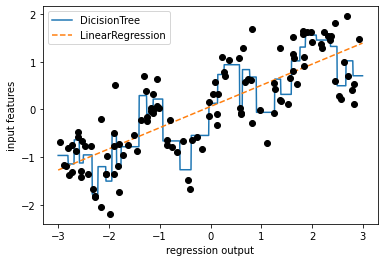

In [109]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

X, y = mglearn.datasets.make_wave(n_samples=120)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

reg = DecisionTreeRegressor(min_samples_leaf=3).fit(X, y)
plt.plot(line, reg.predict(line), label='DicisionTree')

reg = LinearRegression().fit(X, y)
plt.plot(line, reg.predict(line), '--', label='LinearRegression')

plt.plot(X[:, 0], y, 'o', c='k')
plt.xlabel('regression output')
plt.ylabel('input features')
plt.legend(loc='best')

선형 모델은 선형 관계로만 모델링을 하므로 특성이 하나일 땐 직선 형태입니다. 결정 트리는 데이터로 훨씬 복잡한 모델을 만들 수 있습니다. 그러나 데이터의 표현 형태에 따라 굉장히 달라집니다.

연속형 데이터에 아주 강력한 선형 모델을 만드는 방법 중에 하나는 한 특성을 여러 특성으로 나누는 '구간 분할(bining)(=이산화)'입니다. 만약 이 특성의 입력값 범위(-3~3)가 나뉘어 10개 구간으로 되어있다고 가정하면, 각 샘플이 속하는 해당 구간을 나타낼 수 있습니다. 

구간의 경계를 정의하는 여러 방법이 존재합니다. 예컨대 구간의 경계 간의 거리를 같게 하거나 데이터의 분위를 사용할 수 있습니다. 데이터가 많은 구간은 좁습니다. `KBinsDiscretizer` 클래스에 이 방법들이 구현되어 있습니다.

In [110]:
from sklearn.preprocessing import KBinsDiscretizer

# `n_bins` 매개변수에 10을 지정하여 구간 10개를 만듭니다.
kb = KBinsDiscretizer(n_bins=10, strategy='uniform')
kb.fit(X)
# `bin_edges_` 속성에는 특성별 경계값이 (리스트가 아닌)1차원 넘파이 배열로 저장되어 있습니다.
print('bin edges: \n', kb.bin_edges_)

bin edges: 
 [array([-2.9668673 , -2.37804841, -1.78922951, -1.20041062, -0.61159173,
       -0.02277284,  0.56604605,  1.15486494,  1.74368384,  2.33250273,
        2.92132162])]


값이 11개가 출력됐습니다. 10개 특성의 사이값을 나타내므로 1개가 더 출력된 것입니다. 첫 번째 구간에는 특성 값이 -2.967~-2.378인 모든 샘플이 위치합니다. 이런식으로 모든 구간의 값에 해당하는 샘플들이 위치합니다. 

`transform` 메서드를 사용하면 각 샘플을 해당되는 구간으로 인코딩 합니다. `KBinsDiscretizer` 클래스는 기본적으로 구간에 원-핫-인코딩을 적용합니다. 구간마다 새로운 특성 하나가 생기므로 희소 행렬을 만듭니다. 구간 10개를 지정했으므로 변환된 데이터는 특성이 10개인 10차원입니다.

In [111]:
X_binned = kb.transform(X)
X_binned

<120x10 sparse matrix of type '<class 'numpy.float64'>'
	with 120 stored elements in Compressed Sparse Row format>

희소 행렬을 밀집 배열로 변환해서 원본 샘플과 인코딩 결과를 비교합니다.

In [112]:
print(X[:10])
X_binned.toarray()[:10]

[[-0.75275929]
 [ 2.70428584]
 [ 1.39196365]
 [ 0.59195091]
 [-2.06388816]
 [-2.06403288]
 [-2.65149833]
 [ 2.19705687]
 [ 0.60669007]
 [ 1.24843547]]


array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

첫 번째 샘플은 네 번째 구간에 들어갔고, 두 번째 샘플은 열 번째 구간에 들어갔습니다. 이렇게 지속됩니다.

wave 데이터셋의 연속형 특성을 구간에 각 샘플이 속하게 하여 원-핫-인코딩 한 범주형 특성으로 변환했습니다. `encode='ordinal'`로 설정하면 원-핫-인코딩 된 구간의 인덱스를 바로 계산할 수 있지만 유용하지는 않습니다.

예제를 간단하게 만들기 위해 `encode='onehot-dense'`로 지정해서 원-핫-인코딩 된 밀집 배열을 만듭니다. 이 방법을 통해 모든 특성을 바로 출력할 수 있게 됩니다.

In [113]:
kb = KBinsDiscretizer(n_bins=10, strategy='uniform', encode='onehot-dense')
kb.fit(X)
X_binned = kb.transform(X)

원-핫-인코딩 된 데이터로 선형 회귀 모델과 결정 트리 모델을 새로 만듭니다.

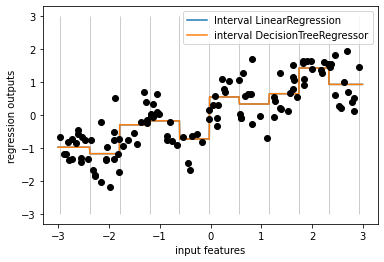

In [114]:
line_binned = kb.transform(line)

reg = LinearRegression().fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='Interval LinearRegression')

reg = DecisionTreeRegressor(min_samples_split=3).fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='interval DecisionTreeRegressor')
plt.plot(X[:, 0], y, 'o', c='k')
plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=.2)
plt.legend(loc='best')
plt.xlabel('input features')
plt.ylabel('regression outputs')
plt.show()

두 모델이 같은 예측을 만들면서 두 종류의 선이 겹쳐졌습니다. 구간별로 두 모델이 예측한 값은 상숫값입니다. 각 구간 안에서는 특성 값이 상수이므로 어떤 모델이든 그 구간의 샘플에 대해서는 같은 값을 예측할 것입니다.

구간으로 나눈 특성을 사용하기 전과 비교하면 각 구간에서 다른 값을 가졌으므로 선형 모델이 훨씬 유연해진 것을 확인할 수 있습니다. 일부 특성과 출력은 비선형 관계에 있지만 용량이 매우 큰 고차원 데이터셋에 선형 모델을 사용한다면 구간 분할을 통해 모델 성능을 제고할 수 있습니다.

결정 트리 모델은 비교적 덜 유연해졌습니다. 결정 트리는 데이터셋에서 예측을 위한 가장 좋은 구간을 학습하고, 한 번에 여러 특성을 살필 수 있습니다. 다시 말하면 트리 모델은 데이터를 자유롭게 나눠서 학습할 수 있습니다. 굳이 특성 값을 구간으로 나눌 필요가 없습니다. 

# 4.5 상호작용과 다항식

특성을 풍부하게 나타내는 방법이 하나 더 있습니다. 원본 데이터에 '상호작용(interaction)'과 '다항식(polynomial)'을 추가하는 것입니다. 이런 종류의 특성 공학은 통계적 모델링뿐만 아니라 머신러닝 애플리케이션에도 많이 사용합니다.

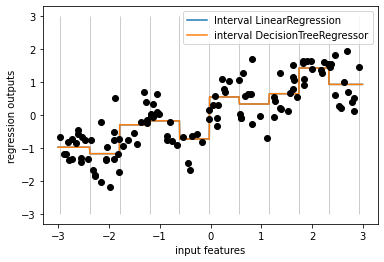

In [115]:
# 개념 설명을 위한 코드입니다.
line_binned = kb.transform(line)

reg = LinearRegression().fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='Interval LinearRegression')

reg = DecisionTreeRegressor(min_samples_split=3).fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='interval DecisionTreeRegressor')
plt.plot(X[:, 0], y, 'o', c='k')
plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=.2)
plt.legend(loc='best')
plt.xlabel('input features')
plt.ylabel('regression outputs')
plt.show()

위에서 출력했던 그래프입니다. 선형 모델은 wave 데이터셋의 각 구간에 대해 상숫값을 학습했습니다. 선형 모델은 이런 절편뿐만 아니라 기울기도 추가로 학습할 수 있습니다. 구간으로 분할된 데이터에 원래 특성(x축)을 다시 추가하여 선형 모델에 기울기를 추가할 수 있습니다. 이 방법을 사용하면 10차원에서 1차원이 더해져서 11차원이 됩니다. 이에 해당하는 그래프를 출력합니다.

In [116]:
X_combined = np.hstack([X, X_binned])
print(X_combined.shape)

(120, 11)


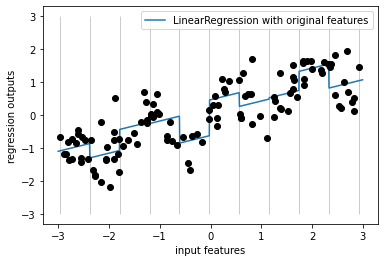

In [117]:
reg = LinearRegression().fit(X_combined, y)
line_combined = np.hstack([line, line_binned])

plt.plot(line, reg.predict(line_combined), label='LinearRegression with original features')
plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=.2)
plt.plot(X[:, 0], y, 'o', c='k')
plt.legend(loc='best')
plt.xlabel('input features')
plt.ylabel('regression outputs')
plt.show()

구간으로 분할된 특성과 기울기 하나를 사용한 선형 회귀 그래프를 출력했습니다. 위 코드에서 각 구간의 절편과 기울기를 학습했습니다. 기울기는 양수입니다. x축 특성이 하나이므로 모든 구간에서 취하는 기울기의 형태는 같습니다. 다만 결코 유익한 형태가 아닙니다. 각 구간에서 다른 기울기를 가지게 하는 게 좋습니다. 이를 위해 샘플이 있는 구간과 x축 사이의 '상호작용' 특성을 추가하는 방법을 사용할 수 있습니다. 상호작용 특성은 구간 특성과 원본 특성의 곱으로 이루어집니다. 아래 코드로 이러한 데이터셋을 만듭니다.

In [118]:
X_product = np.hstack([X_binned, X * X_binned])
print(X_product.shape)

(120, 20)


샘플이 속한 구간, 구간에 원본 특성을 곱한 값으로 이루어진 특성 20개를 가지게 되었습니다. 후자의 특성은 각 구간에 대한 x축 특성의 복사본으로 볼 수 있으며, 구간 안에서는 원본 특성이고 다른 곳에서는 0입니다. 'X_binned'는 샘플이 속한 구간의 원-핫-인코딩이므로 X를 곱하면 해당 구간 외에는 결국 0이 되는 것입니다. 

추가한 특성 20개를 토대로 선형 모델을 만듭니다.

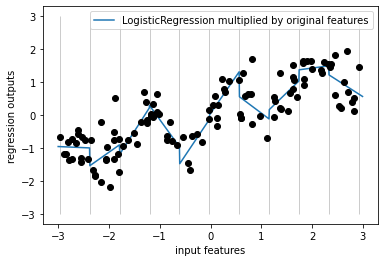

In [119]:
reg = LinearRegression().fit(X_product, y)
line_product = np.hstack([line_binned, line * line_binned])

plt.plot(line, reg.predict(line_product), label='LogisticRegression multiplied by original features')
plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=.2)
plt.plot(X[:, 0], y, 'o', c='k')
plt.legend(loc='best')
plt.xlabel('input features')
plt.ylabel('regression outputs')
plt.show()

절편과 기울기 모두 다른 형태입니다.

원본 특성의 다항식을 추가하는 방법도 있습니다. `PolynomialFeatures` 클래스에 이 방법이 구현되어 있습니다. 특성 x 가 주어지면 x ** 2, x ** 3, x ** 4 등을 만듭니다. 

In [120]:
from sklearn.preprocessing import PolynomialFeatures

# 고차항을 x ** 10까지 추가합니다.
# `include_bias=False`는 기본값을 지정한 매개변수입니다.
# 이를 통해 절편에 해당하는 1인 특성을 추가합니다.
# 'include_bias=True`로 지정하면 절편을 고려해서 특성 11개를 생성합니다.
poly = PolynomialFeatures(degree=10, include_bias=False)
poly.fit(X)
X_poly = poly.transform(X)
print(X_poly.shape)

(120, 10)


10차원을 지정했으므로 'x ** 1'부터 'x ** 10'까지 특성 10개가 만들어졌습니다. 

'X'와 'X_poly'의 값을 확인합니다.

In [121]:
print('X 원소:\n', X[:5])
print('X_poly 원소:\n', X_poly[:5])

X 원소:
 [[-0.75275929]
 [ 2.70428584]
 [ 1.39196365]
 [ 0.59195091]
 [-2.06388816]]
X_poly 원소:
 [[-7.52759287e-01  5.66646544e-01 -4.26548448e-01  3.21088306e-01
  -2.41702204e-01  1.81943579e-01 -1.36959719e-01  1.03097700e-01
  -7.76077513e-02  5.84199555e-02]
 [ 2.70428584e+00  7.31316190e+00  1.97768801e+01  5.34823369e+01
   1.44631526e+02  3.91124988e+02  1.05771377e+03  2.86036036e+03
   7.73523202e+03  2.09182784e+04]
 [ 1.39196365e+00  1.93756281e+00  2.69701700e+00  3.75414962e+00
   5.22563982e+00  7.27390068e+00  1.01250053e+01  1.40936394e+01
   1.96178338e+01  2.73073115e+01]
 [ 5.91950905e-01  3.50405874e-01  2.07423074e-01  1.22784277e-01
   7.26822637e-02  4.30243318e-02  2.54682921e-02  1.50759786e-02
   8.92423917e-03  5.28271146e-03]
 [-2.06388816e+00  4.25963433e+00 -8.79140884e+00  1.81444846e+01
  -3.74481869e+01  7.72888694e+01 -1.59515582e+02  3.29222321e+02
  -6.79478050e+02  1.40236670e+03]]


각 특성의 차수를 담은 `get_feature_names` 메서드를 사용해서 특성의 의미를 확인합니다.

In [122]:
print('항 이름:\n', poly.get_feature_names())

항 이름:
 ['x0', 'x0^2', 'x0^3', 'x0^4', 'x0^5', 'x0^6', 'x0^7', 'x0^8', 'x0^9', 'x0^10']


다항식 특성을 선형 모델과 함께 사용하면 '다항 회귀(polynomial regression)' 모델이 됩니다. 이 모델을 표현한 그래프를 출력합니다.

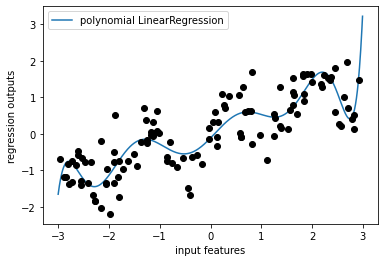

In [123]:
reg = LinearRegression().fit(X_poly, y)
line_poly = poly.transform(line)

plt.plot(line, reg.predict(line_poly), label='polynomial LinearRegression')
plt.plot(X[:, 0], y, 'o', c='k')
plt.legend(loc='best')
plt.xlabel('input features')
plt.ylabel('regression outputs')
plt.show()

다항식 특성은 1차원 데이터셋에서도 부드러운 곡선을 가집니다. 그러나 고차원 다항식은 데이터가 부족한 영역에서는 민감하게 동작합니다. 그래프의 시작점과 끝점에서 급격한 상승 곡선과 하락 곡선 형태를 띱니다.

비교를 위해 원본 데이터에 커널 SVM 모델을 학습시켜서 확인합니다.

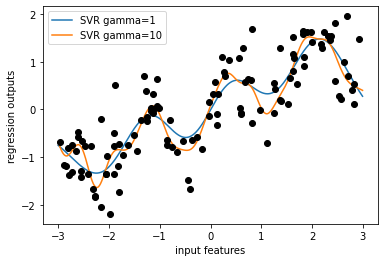

In [124]:
from sklearn.svm import SVR

for gamma in [1, 10]:
    svr = SVR(gamma=gamma).fit(X, y)
    plt.plot(line, svr.predict(line), label='SVR gamma={}'.format(gamma))

plt.plot(X[:, 0], y, 'o', c='k')
plt.legend(loc='best')
plt.xlabel('input features')
plt.ylabel('regression outputs')
plt.show()

더 복잡한 모델인 커널 SVM을 사용해서 특성 데이터를 변환하지 않고 다항 회귀와 비슷한 복잡도를 가진 예측을 만들었습니다.

보스턴 주택 가격 데이터셋을 이용해서 상호작용과 다항식에 대해 더 살핍니다. 먼저 데이터셋을 읽어 들여서 `MinMaxSCaler` 클래스를 사용하여 0에서 1로 스케일을 조정합니다.

In [126]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 4.6 일변량 비선형 변환

# 4.7 특성 자동 선택

## 4.7.1 일변량 통계

## 4.7.2 모델 기반 특성 선택

## 4.7.3 반복적 특성 선택

# 4.8 전문가 지식 활용

# 4.9 요약 및 정리